In [93]:
!pip install minisom imbalanced-learn

Para começar, irei fazer todos os imports necessarios e estou usando o KAggle hub para poder utilizar a base de forma simplificada e direta

In [94]:

import kagglehub
from kagglehub import KaggleDatasetAdapter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.ensemble import IsolationForest
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, silhouette_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.cluster import KMeans, DBSCAN
from minisom import MiniSom

file_path = "creditcard.csv"

df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "mlg-ulb/creditcardfraud",
  file_path,
)

sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

/tmp/ipython-input-1530193240.py:20: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  df = kagglehub.load_dataset(


Using Colab cache for faster access to the 'creditcardfraud' dataset.


In [95]:
print("1) Visualização da base de dados")
print("-------------------------------")
print("Colunas:", df.columns)
print("-------------------------------")
print("Shape(LinhasxColunas):", df.shape)
print("-------------------------------")
print(df.info())
print("-------------------------------")
print(df.head())

1) Visualização da base de dados
-------------------------------
Colunas: Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')
-------------------------------
Shape(LinhasxColunas): (284807, 31)
-------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  fl

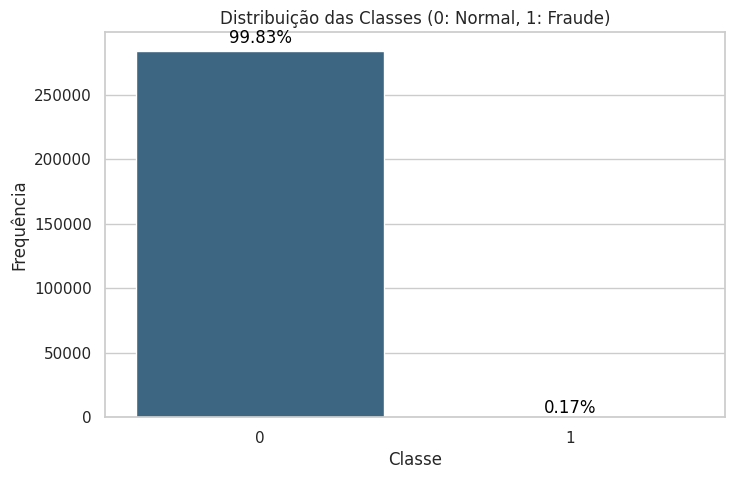

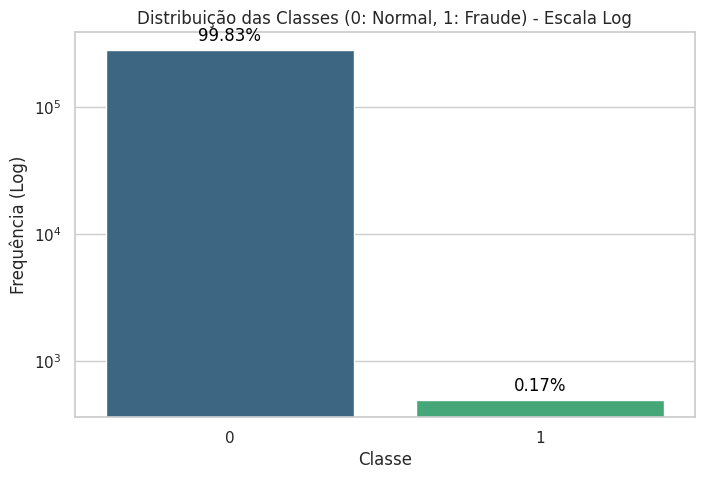

In [96]:
total = len(df)

plt.figure(figsize=(8, 5))
ax1 = sns.countplot(x='Class', data=df, palette='viridis', hue='Class')

if ax1.legend_:
    ax1.legend_.remove()

plt.title('Distribuição das Classes (0: Normal, 1: Fraude)')
plt.xlabel('Classe')
plt.ylabel('Frequência')

for p in ax1.patches:
    height = p.get_height()
    if height > 0:
        ax1.text(p.get_x() + p.get_width() / 2., height + (height * 0.01),
                '{:.2f}%'.format((height / total) * 100),
                ha="center", va='bottom', fontsize=12, color='black')
plt.show()

plt.figure(figsize=(8, 5))
ax2 = sns.countplot(x='Class', data=df, palette='viridis', hue='Class')

if ax2.legend_:
    ax2.legend_.remove()

plt.title('Distribuição das Classes (0: Normal, 1: Fraude) - Escala Log')
plt.xlabel('Classe')
plt.ylabel('Frequência (Log)')
plt.yscale('log')

for p in ax2.patches:
    height = p.get_height()
    if height > 0:
        ax2.text(p.get_x() + p.get_width() / 2., height * 1.1,
                '{:.2f}%'.format((height / total) * 100),
                ha="center", va='bottom', fontsize=12, color='black')
plt.show()

In [97]:
print("2) Verificação de Valores Ausentes e 3) Eliminação de Redundância")
print(f"Shape pré limpeza: {df.shape}")
print(f"Nulos antes: {df.isnull().sum().max()}")

print(f"Duplicatas antes: {df.duplicated().sum()}")

df.drop_duplicates(inplace=True)

print(f"Shape final após limpeza: {df.shape}")

2) Verificação de Valores Ausentes e 3) Eliminação de Redundância
Shape pré limpeza: (284807, 31)
Nulos antes: 0
Duplicatas antes: 1081
Shape final após limpeza: (283726, 31)


4) Detecção e tratamento de outliers


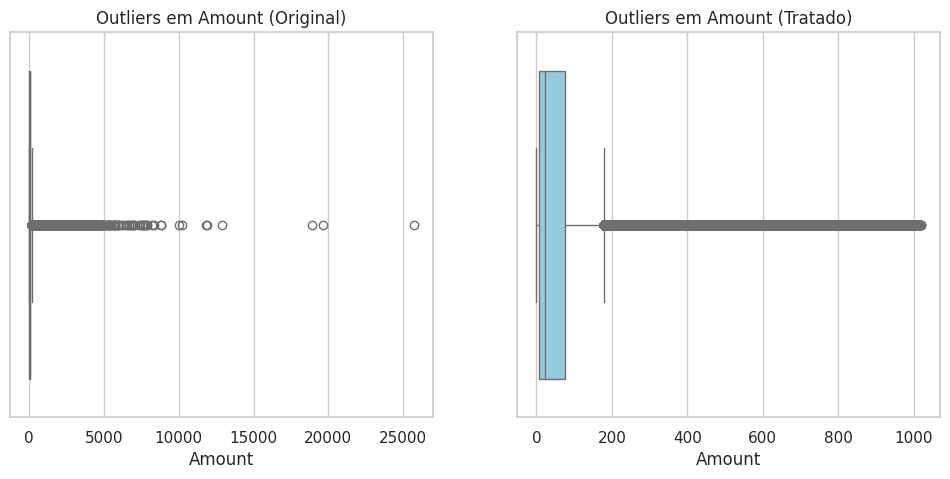

Registros removidos: 2838


In [98]:
print("4) Detecção e tratamento de outliers")

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.boxplot(x=df['Amount'], color='salmon')
plt.title('Outliers em Amount (Original)')

limite = df['Amount'].quantile(0.99)
df_clean = df[df['Amount'] < limite].copy()

plt.subplot(1, 2, 2)
sns.boxplot(x=df_clean['Amount'], color='skyblue')
plt.title('Outliers em Amount (Tratado)')
plt.show()

print(f"Registros removidos: {len(df) - len(df_clean)}")

6) Análise de correlação


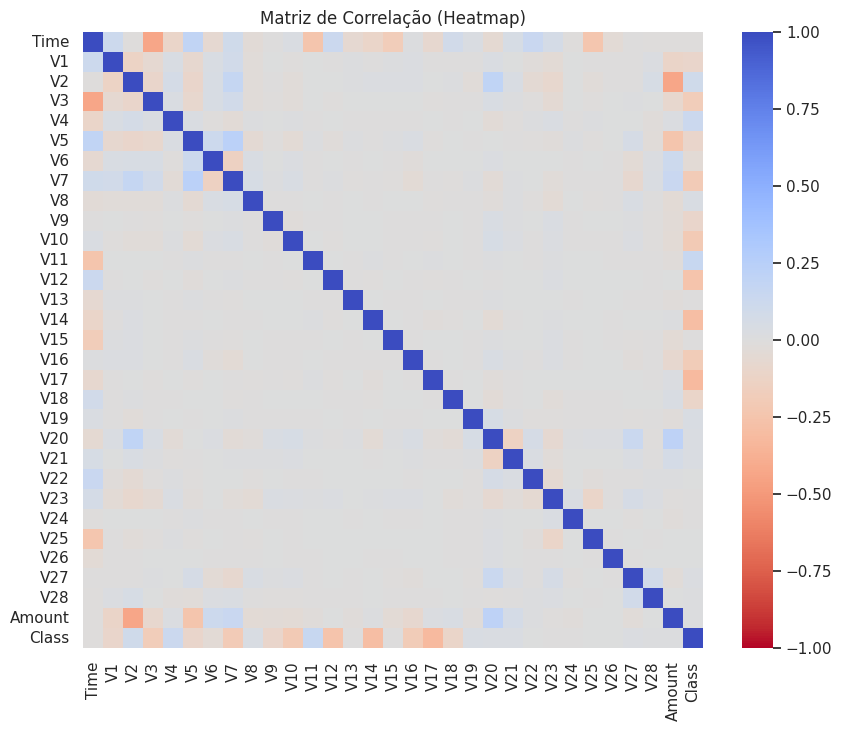

In [99]:
print("6) Análise de correlação")

plt.figure(figsize=(10, 8))
corr = df_clean.corr()

sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size': 20}, vmin=-1, vmax=1)
plt.title("Matriz de Correlação (Heatmap)")
plt.show()

In [100]:
print("5) Normalização e 9) Divisão Treino-Teste")

X = df_clean.drop('Class', axis=1)
y = df_clean['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = RobustScaler()

X_train[['Amount', 'Time']] = scaler.fit_transform(X_train[['Amount', 'Time']])
X_test[['Amount', 'Time']] = scaler.transform(X_test[['Amount', 'Time']])

print("Dados normalizados e divididos.")
print(f"Treino: {X_train.shape}, Teste: {X_test.shape}")

5) Normalização e 9) Divisão Treino-Teste
Dados normalizados e divididos.
Treino: (224710, 30), Teste: (56178, 30)


8) Balanceamento da classe


/tmp/ipython-input-2641557274.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_train, ax=ax[0], palette="Blues")
/tmp/ipython-input-2641557274.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_train_res, ax=ax[1], palette="Oranges")


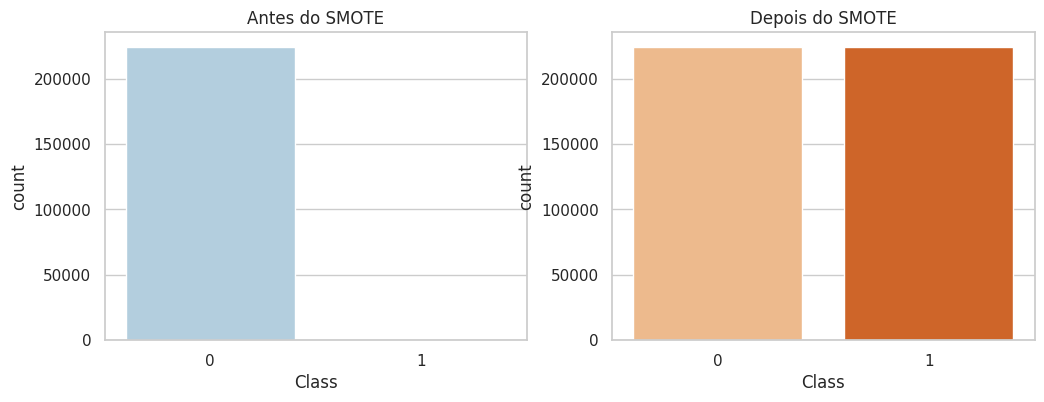

In [101]:
print("8) Balanceamento da classe")

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

sns.countplot(x=y_train, ax=ax[0], palette="Blues")
ax[0].set_title("Antes do SMOTE")

sns.countplot(x=y_train_res, ax=ax[1], palette="Oranges")
ax[1].set_title("Depois do SMOTE")

plt.show()

Questão 2: Algoritmos de Agrupamento - K-Means e DBSCAN
Silhouette K-Means: 0.332
Silhouette DBSCAN: 0.370


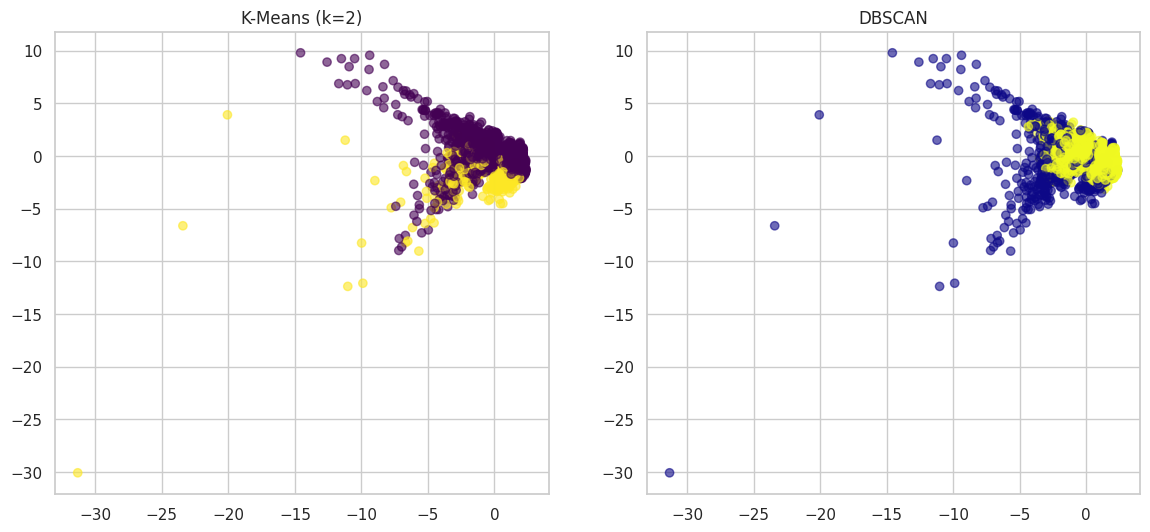

In [102]:
print("Questão 2: Algoritmos de Agrupamento - K-Means e DBSCAN")

X_sample = X_test.sample(5000, random_state=42)

kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
labels_k = kmeans.fit_predict(X_sample)
sil_k = silhouette_score(X_sample, labels_k)

dbscan = DBSCAN(eps=4.0, min_samples=20)
labels_d = dbscan.fit_predict(X_sample)
if len(set(labels_d)) > 1:
    sil_d = silhouette_score(X_sample, labels_d)
else:
    sil_d = -1

print(f"Silhouette K-Means: {sil_k:.3f}")
print(f"Silhouette DBSCAN: {sil_d:.3f}")

fig, ax = plt.subplots(1, 2, figsize=(14, 6))

ax[0].scatter(X_sample['V1'], X_sample['V2'], c=labels_k, cmap='viridis', alpha=0.6)
ax[0].set_title('K-Means (k=2)')

ax[1].scatter(X_sample['V1'], X_sample['V2'], c=labels_d, cmap='plasma', alpha=0.6)
ax[1].set_title('DBSCAN')

plt.show()

SOM
Treinando SOM
Treinamento concluído


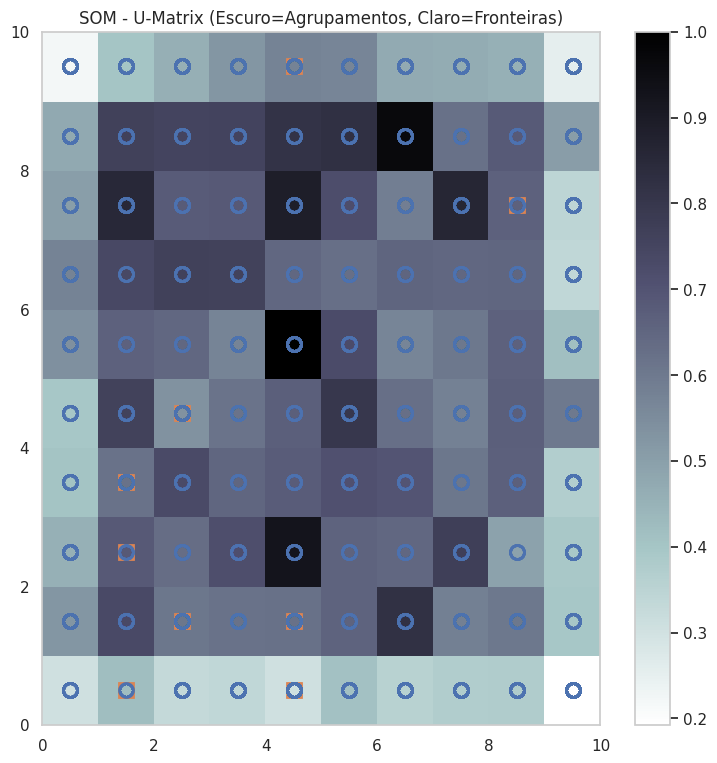

Silhouette Score (SOM): 0.049


In [107]:
print("SOM")

min_max_scaler = MinMaxScaler()
X_som = min_max_scaler.fit_transform(X_sample)

som_map_size = 10
som = MiniSom(x=som_map_size, y=som_map_size, input_len=X_som.shape[1], sigma=1.0, learning_rate=0.5)

som.random_weights_init(X_som)
print("Treinando SOM")
som.train_random(data=X_som, num_iteration=1000)
print("Treinamento concluído")

plt.figure(figsize=(9, 9))
plt.pcolor(som.distance_map().T, cmap='bone_r')
plt.colorbar()

markers = ['o', 's']
colors = ['C0', 'C1']
for i, x in enumerate(X_som):
    w = som.winner(x)
    plt.plot(w[0] + 0.5, w[1] + 0.5,
             markers[y_test.iloc[i] if i < len(y_test) else 0],
             markerfacecolor='None',
             markeredgecolor=colors[y_test.iloc[i] if i < len(y_test) else 0],
             markersize=10,
             markeredgewidth=2)

plt.title('SOM - U-Matrix (Escuro=Agrupamentos, Claro=Fronteiras)')
plt.show()

som_weights = som.get_weights().reshape(-1, X_som.shape[1])

kmeans_som = KMeans(n_clusters=2, random_state=42, n_init=10)
neuron_clusters = kmeans_som.fit_predict(som_weights)

predicted_labels_som = []
for d in X_som:
    w = som.winner(d)
    winner_idx = w[0] * som_map_size + w[1]
    predicted_labels_som.append(neuron_clusters[winner_idx])


sil_som = silhouette_score(X_sample, predicted_labels_som)
print(f"Silhouette Score (SOM): {sil_som:.3f}")